## **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import zipfile
import os
import requests

## **Loading Data**

In [ ]:
# Download and extract the dataset
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip"
file_name = "electricity_data.zip"
dataset_folder = "electricity_dataset"

In [2]:
if not os.path.exists(dataset_folder):
    print("Downloading dataset...")
    response = requests.get(data_url)
    with open(file_name, "wb") as file:
        file.write(response.content)
    print("Extracting dataset...")
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        zip_ref.extractall(dataset_folder)
    os.remove(file_name)

Extracting dataset...


In [3]:
# Load data
data_path = os.path.join(dataset_folder, "LD2011_2014.txt")
data = pd.read_csv(data_path, sep=";", index_col=0, parse_dates=True, decimal=',')
data = data.resample('H').sum()  # Resample to hourly data

<ipython-input-3-a37e89b57e03>:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.resample('H').sum()  # Resample to hourly data


In [6]:
# Use one column for demonstration
data = data.iloc[:, 0].to_frame(name='demand')
data = data.fillna(method='ffill')

<ipython-input-6-8e59f65de39e>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


In [7]:
# Ensure datetime format
data = data.reset_index()
data.rename(columns={"index": "datetime"}, inplace=True)
data['datetime'] = pd.to_datetime(data['datetime'])
data = data.set_index('datetime')

## **Feature Engineering**

In [8]:
# Create lag features
for lag in range(1, 25):  # Lagging up to 24 hours
    data[f'demand_lag_{lag}'] = data['demand'].shift(lag)

# Add temporal features
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['month'] = data.index.month

## **Data Preprocessing**

In [9]:
# Drop rows with NaN values caused by lagging
data = data.dropna()

In [10]:
# Train-test split
train_size = 0.8
train_data = data[:int(len(data) * train_size)]
test_data = data[int(len(data) * train_size):]

In [11]:
# Separate features and target
X_train = train_data.drop(columns=['demand'])
y_train = train_data['demand']
X_test = test_data.drop(columns=['demand'])
y_test = test_data['demand']

In [12]:
# Normalize features for LSTM
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
# Reshape for LSTM (samples, time steps, features)
time_steps = 24
X_train_lstm = np.array([X_train_scaled[i:i+time_steps] for i in range(len(X_train_scaled) - time_steps)])
y_train_lstm = y_train[time_steps:]
X_test_lstm = np.array([X_test_scaled[i:i+time_steps] for i in range(len(X_test_scaled) - time_steps)])
y_test_lstm = y_test[time_steps:]


## **Model Building**

In [14]:
# Baseline Model: Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

In [15]:
# Evaluation for Baseline
mae_lr = mean_absolute_error(y_test, lr_predictions)
mse_lr = mean_squared_error(y_test, lr_predictions)
print(f"Baseline Model - MAE: {mae_lr}, MSE: {mse_lr}")

Baseline Model - MAE: 4.859752495066525, MSE: 92.88347216183914


## **LSTM Model Builing**

In [16]:
# LSTM Model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(time_steps, X_train_scaled.shape[1])),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
# Train the model
history = lstm_model.fit(X_train_lstm, y_train_lstm, epochs=30, batch_size=64, validation_split=0.2, verbose=1)

Epoch 1/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - loss: 142.9042 - val_loss: 199.6749
Epoch 2/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - loss: 127.9064 - val_loss: 207.9993
Epoch 3/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - loss: 129.5758 - val_loss: 216.6414
Epoch 4/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - loss: 130.7219 - val_loss: 249.9828
Epoch 5/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - loss: 121.1884 - val_loss: 341.7432
Epoch 6/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 114.5502 - val_loss: 181.3000
Epoch 7/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 116.3928 - val_loss: 216.5268
Epoch 8/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 117.4159 - val_loss: 255.1392
Epoch 9/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 119.5337 - val_loss: 224.2407
Epoch 10/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 112.8198 - val_loss: 128.4491
Epoch 11/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 114.8630 - val_loss

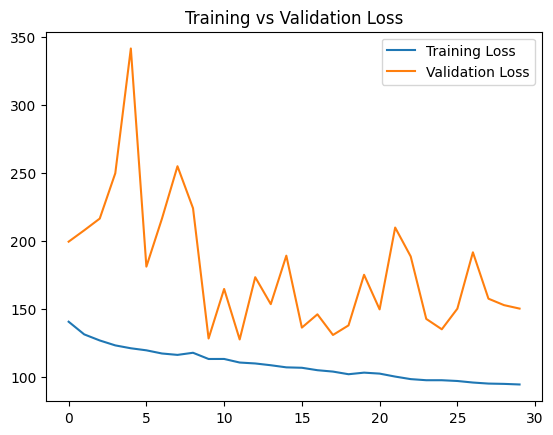

In [22]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

In [19]:
# Evaluate LSTM
lstm_predictions = lstm_model.predict(X_test_lstm)
lstm_mae = mean_absolute_error(y_test_lstm, lstm_predictions)
lstm_mse = mean_squared_error(y_test_lstm, lstm_predictions)
print(f"LSTM Model - MAE: {lstm_mae}, MSE: {lstm_mse}")

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
LSTM Model - MAE: 6.949805858683706, MSE: 158.52296915526273


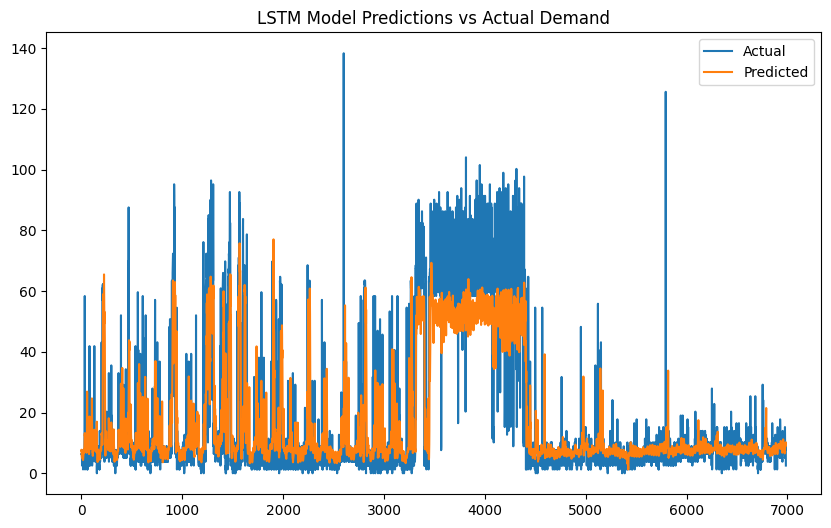

In [20]:
# Visualization
plt.figure(figsize=(10, 6))
plt.plot(y_test_lstm.values, label='Actual')
plt.plot(lstm_predictions, label='Predicted')
plt.legend()
plt.title('LSTM Model Predictions vs Actual Demand')
plt.show()